# 데이터 불러오기

In [1]:
# 필요한 모듈 불러오기
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch

# 필요한 모듈 가져오기
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
import plotly.offline as py
import plotly.graph_objs as go
%matplotlib inline

In [66]:
# 데이터 로드
base = os.getcwd()
img = Image.open(base + '\\data\\test_img_20200424_1.jpg')

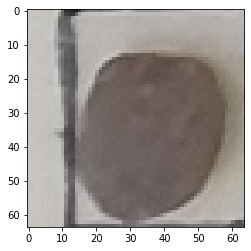

In [80]:
img = torch.LongTensor(np.array(img))
img_tmp = img[1866:1994,46:174,:]
img_final = img_tmp[64:128,0:64,:]
plt.imshow(img_final.numpy())

# 이미지 데이터 탐색 및 전처리
- 자연환경에서 얻은 이미지는 반드시 전처리가 필요하다


In [94]:
# 이미지 데이터 확인
img_final.size()

torch.Size([64, 64, 3])

In [95]:
# 3차원 이미지 확인 함수

py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=500,
        height=500,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [98]:
# 보기가 불편하다 역상으로 전환
img_final_rev = torch.Tensor([255]) - img_final

In [102]:
# 3차원 이미지 확인
# 3차원 이미지를 확인하면서 픽셀 값들이 어떻게 나타나는지 확인
# 3차원 이미지를 확인하면서 픽셀 값들이 어떻게 나타나는지 확인
# 이미지를 이해하는데 큰 도움이 된다
plotmy3d(img_final_rev[:,:,0], 'green bean')

# 이미지 객체 따기

In [105]:
# 바이너리 데이터로 전환
gray = cv2.cvtColor(img_final_rev.numpy(), cv2.COLOR_RGB2GRAY)
ret, img_final_rev_thr = cv2.threshold(gray, 118, 255, cv2.THRESH_BINARY)

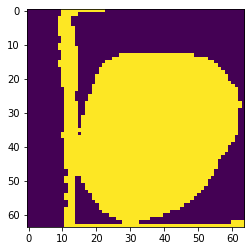

In [106]:
# 바이너리 이미지 확인
plt.imshow(img_final_rev_thr)

In [107]:
# 위에서 이미지 확인 후 , 필요 없는 부분들은 데이터 삭제
img_final_rev_thr
img_final_rev_thr[0:3,:] = 0
img_final_rev_thr[61:64,:] = 0
img_final_rev_thr[:,0:15] = 0

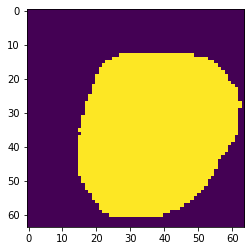

In [108]:
# 이미지 처리 후 재확인
plt.imshow(img_final_rev_thr)

In [113]:
# 데이터 저장
img_object = img_final_rev_thr
img_object.shape

(64, 64)

# 무게 중심 구하기

In [110]:
# 무게중심 구하기
def calculateMassCenter(img):

  height = img.shape[0]
  width = img.shape[1]

  R = list()
  for y in range(height):
    for x in range(width):
      if img[y,x]:            
        R.append([x, (height-y)*1j])

  # 질량의 합
  M = len(R)

  # 질량중심 벡터는 이미지를 기준으로 (x,y) => (height-y)
  R = np.array(R)
  R_x = R[:,0]
  R_y = R[:,1]

  R_x_sum = R_x.sum()
  R_y_sum = R_y.sum()

  center = np.round(R_x_sum/M).real , (np.round(R_y_sum/M)*-1j).real
 
  height_center = center[1]
  width_center = center[0]
  return width_center, height_center, M, R

In [111]:
calculateMassCenter(img_object)

(37.0, 28.0, 1848, array([[27. +0.j,  0.+51.j],
        [28. +0.j,  0.+51.j],
        [29. +0.j,  0.+51.j],
        ...,
        [37. +0.j,  0. +4.j],
        [38. +0.j,  0. +4.j],
        [39. +0.j,  0. +4.j]]))

In [54]:
# 이미지의 중심과 객체의 중심을 일치시키는 알고리즘을 구현하자

# 1. 이미지 센터 좌표를 구한다 
img_center = np.array([img_object.shape[1] / 2, img_object.shape[0] / 2]) # (x, y)

# 2. 객체의 중심을 구한다
object_center = np.array([calculateMassCenter(img_object)[1], calculateMassCenter(img_object)[0]]) # (x, y)

# 3. 이미지 중심과 객체의 중심의 차이를 구한다
delta = object_center - img_center # (x, y)

# 4. 이미지 이동
height, width = img_object.shape[:2]
M = np.float32([[1, 0, delta[0]], [0, 1, -delta[1]]]) # 이미지를 width 방향으로 delta[0]만큼 , hiehgt 방향으로 -delta[1]만큼
img_translation = cv2.warpAffine(img_object, M, (width,height))

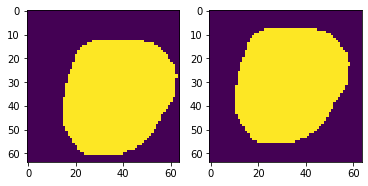

In [55]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(img_object)
ax2.imshow(img_translation)

# 이미지 컨투어 따기

In [59]:
ret, img_final_rev_thr = cv2.threshold(img_translation, 118, 255, cv2.THRESH_BINARY)
img_final_rev_thr = cv2.bitwise_not(img_final_rev_thr)

contours, hierachy = cv2.findContours(img_translation, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

for i in range(len(contours)):
    cv2.drawContours(img_translation, [contours[i]], 0, (0, 0, 255), 2)
    cv2.putText(img_translation, str(i), tuple(contours[i][0][0]),cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 0), 1)
    print(i, hierachy[0][i])
    cv2.imshow("img_final", img_translation,)
    cv2.waitKey(0)

cv2.destroyAllWindows()

0 [-1 -1 -1 -1]


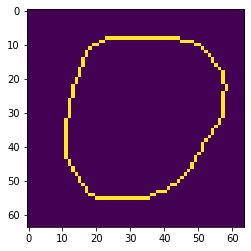

In [64]:
tmp = np.zeros_like(img_translation)
for i in contours[0]:
    tmp[i[0][1], i[0][0]] = 255
img_contour = tmp

plt.imshow(img_contour)